In [116]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Leitura Dados

In [3]:
X = pd.read_csv('./2d/sr3/X_train.csv').drop(columns=['index', 'Unnamed: 0'])
y = pd.read_csv('./2d/sr3/y_train.csv').drop(columns=['index', 'Unnamed: 0'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_test = pd.read_csv('./2d_test/sr3/X_test.csv').drop(columns=['index', 'Unnamed: 0'])
y_test = pd.read_csv('./2d_test/sr3/y_test.csv').drop(columns=['index', 'Unnamed: 0'])


In [9]:
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

print('')
print(f'Input shape: {X_train.shape}')
print(f'Output shape: {y_train.shape}')

Train: 9665
Validation: 3222
Test: 1315

Input shape: (9665, 225)
Output shape: (9665, 175)


In [19]:
def df2tensor(df, ni, nj):
    t1 = torch.tensor(df.values)
    t2 = torch.reshape(t1, (len(df), -1, ni, nj))
    return t2.float()

In [21]:
X_train_t = df2tensor(X_train, 5, 5)
y_train_t = df2tensor(y_train, 5, 5)

X_val_t = df2tensor(X_val, 5, 5)
y_val_t = df2tensor(y_val, 5, 5)

X_test_t = df2tensor(X_test, 5, 5)
y_test_t = df2tensor(y_test, 5, 5)

In [36]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {
            'X': self.X[idx],
            'y': self.y[idx]
        }
        return sample

In [37]:
data_train = CustomDataset(X_train_t, y_train_t)
data_val = CustomDataset(X_val_t, y_val_t)
data_test = CustomDataset(X_test_t, y_test_t)

In [38]:
batch_size = 16  # Tamanho do lote
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [42]:
for i in dataloader_val:
    X = i['X']
    y = i['y']
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {y.shape}')
    break

Input shape: torch.Size([16, 9, 5, 5])
Output shape: torch.Size([16, 7, 5, 5])


## Neural Network

In [62]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, latent_size, max_size, recurrences):
        super(Network,self).__init__()
        self.enc_1 = nn.Conv2d( input_size,  input_size, 1, padding=0)
        self.enc_2 = nn.Conv2d( input_size, latent_size, 1, padding=0)
        self.enc_3 = nn.Conv2d(latent_size, latent_size, 1, padding=0)

        self.proc_1 = nn.Conv2d(latent_size, latent_size, 3, padding=1)
        self.proc_2 = nn.Conv2d(latent_size,    max_size, 3, padding=1)
        self.proc_3 = nn.Conv2d(   max_size,    max_size, 3, padding=1)
        self.proc_4 = nn.Conv2d(   max_size, latent_size, 3, padding=1)

        self.dec_1 = nn.Conv2d( latent_size, latent_size, 1, padding=0)
        self.dec_2 = nn.Conv2d( latent_size, output_size, 1, padding=0)
        self.dec_3 = nn.Conv2d( output_size, output_size, 1, padding=0)

        self.recurrences = recurrences

    def forward(self, x):
        x = self.enc_1(x)
        x = F.relu(x)
        x = self.enc_2(x)
        x = F.relu(x)
        x = self.enc_3(x)
        x = F.relu(x)

        for _ in range(self.recurrences):
            x = self.proc_1(x)
            x = F.relu(x)
            x = self.proc_2(x)
            x = F.relu(x)
            x = self.proc_3(x)
            x = F.relu(x)
            x = self.proc_4(x)
            x = F.relu(x)

        x = self.dec_1(x)
        x = F.relu(x)
        x = self.dec_2(x)
        x = F.relu(x)
        x = self.dec_3(x)
        return x

In [90]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=16,
    max_size=32,
    recurrences=5)

some_data = X_train_t
print(some_data.shape)
loss_fn = nn.MSELoss()
result = model(some_data)
print(result.shape)

loss = loss_fn(result, y_train_t)
loss.backward()
print(f'Loss = {loss}')

torch.Size([9665, 9, 5, 5])
torch.Size([9665, 7, 5, 5])
Loss = 27238.05859375


In [78]:
torch.onnx.export(model, X_test_t, 'test.onnx', input_names=["features"], output_names=["results"])
# https://machinelearningmastery.com/visualizing-a-pytorch-model/
# https://netron.app/

In [79]:
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Parameters: {param.numel()}")
    total += param.numel()
print(f'Total: {total}')

Layer: enc_1.weight | Parameters: 81
Layer: enc_1.bias | Parameters: 9
Layer: enc_2.weight | Parameters: 144
Layer: enc_2.bias | Parameters: 16
Layer: enc_3.weight | Parameters: 256
Layer: enc_3.bias | Parameters: 16
Layer: proc_1.weight | Parameters: 2304
Layer: proc_1.bias | Parameters: 16
Layer: proc_2.weight | Parameters: 4608
Layer: proc_2.bias | Parameters: 32
Layer: proc_3.weight | Parameters: 9216
Layer: proc_3.bias | Parameters: 32
Layer: proc_4.weight | Parameters: 4608
Layer: proc_4.bias | Parameters: 16
Layer: dec_1.weight | Parameters: 256
Layer: dec_1.bias | Parameters: 16
Layer: dec_2.weight | Parameters: 112
Layer: dec_2.bias | Parameters: 7
Layer: dec_3.weight | Parameters: 49
Layer: dec_3.bias | Parameters: 7
Total: 21801


## Ajuste

=> Starting training
=> epoch: 1, train: 541, val: 5.315
=> epoch: 2, train: 312.5, val: 4.454
=> epoch: 3, train: 278.4, val: 3.538
=> epoch: 4, train: 185.6, val: 2.885
=> epoch: 5, train: 188.4, val: 2.307
=> epoch: 6, train: 324.5, val: 1.81
=> epoch: 7, train: 118.8, val: 1.358
=> epoch: 8, train: 177.2, val: 1.07
=> epoch: 9, train: 43.3, val: 0.6293
=> epoch: 10, train: 45.66, val: 0.4163
=> epoch: 11, train: 18.67, val: 0.2805
=> epoch: 12, train: 14.48, val: 0.2298
=> epoch: 13, train: 100.4, val: 0.3842
=> epoch: 14, train: 43.43, val: 0.2213
=> epoch: 15, train: 15.64, val: 0.1743
=> epoch: 16, train: 9.67, val: 0.1651
=> epoch: 17, train: 9.08, val: 0.1556
=> epoch: 18, train: 8.483, val: 0.1444
=> epoch: 19, train: 8.009, val: 0.1383
=> epoch: 20, train: 7.186, val: 0.1209
=> epoch: 21, train: 6.834, val: 0.117
=> epoch: 22, train: 6.37, val: 0.1055
=> epoch: 23, train: 5.814, val: 0.09496
=> epoch: 24, train: 14.79, val: 0.1027
=> epoch: 25, train: 12.24, val: 0.2933
=> e

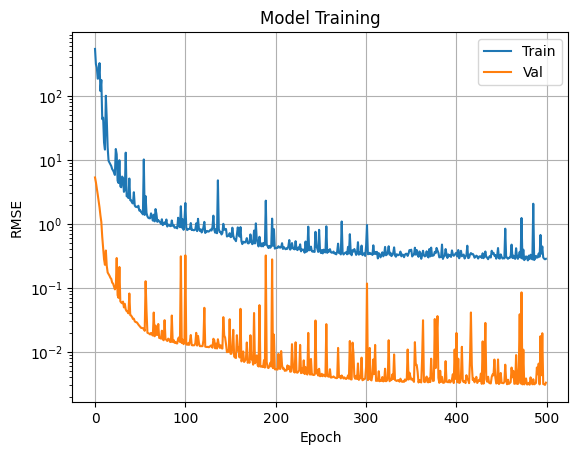

In [137]:
def train(model: Network,
          data: DataLoader,
          val_data: DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module) -> None:
    train_losses = {}
    val_losses = {}
    # model.to(device)

    best_val = np.inf
    model.train()
    print("=> Starting training")
    for epoch in range(epochs):
        train_loss = list()
        val_loss = list()
        for data_ in data:
            X = data_['X'] #.to(device)
            y = data_['y'] #.to(device)

            out = model(X)
            loss = loss_fn(out, y)
            model.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().item() / X.shape[0])
        for data_ in val_data:
            X = data_['X'] #.to(device)
            y = data_['y'] #.to(device)

            out = model(X)
            loss = loss_fn(out, y)

            val_loss.append(loss.detach().item() / X.shape[0])

        if val_loss[-1] < best_val:
            best_val = val_loss[-1]
            torch.save(model, 'model.pth')

        train_losses[epoch] = float(torch.tensor(train_loss).mean())
        val_losses[epoch] = float(torch.tensor(val_loss).mean())
        print(f'=> epoch: {epoch + 1}, train: {train_losses[epoch]:0.4g}, val: {val_losses[epoch]:0.4g}')
        # print(generate_text(model, data.dataset))
    best_model = torch.load('model.pth')
    return best_model, (train_losses, val_losses)

model = Network(
    input_size=9,
    output_size=7,
    latent_size=16,
    max_size=32,
    recurrences=1)
loss_fn = nn.MSELoss()

batch_size = 64  # Tamanho do lote
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

best_model, losses = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn)

plot_losses(losses)


In [135]:
def plot_losses(losses):
    plt.plot(losses[0].values(), label='Train')
    plt.plot(losses[1].values(), label='Val')
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Model Training")
    plt.legend()
    plt.grid(True)
    plt.show()

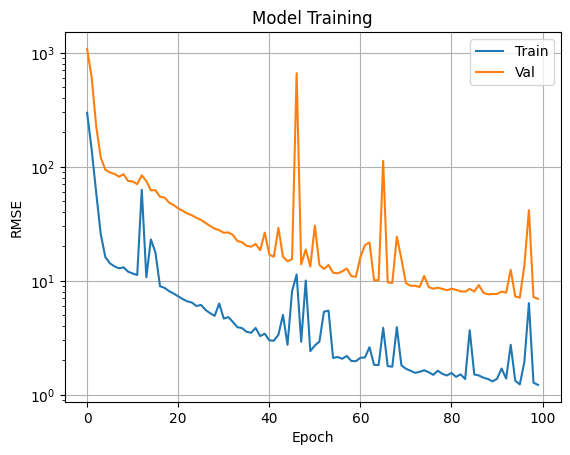

In [136]:
plot_losses(losses)

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very \"pure\" way,
as regular feed-forward layers.

This RNN module implements a \"vanilla RNN\" an is just 3 linear layers
which operate on an input and hidden state, with a `LogSoftmax` layer
after the output.


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9749, -2.6424, -2.9224, -2.8273, -3.0181, -3.0578, -2.8341, -2.9614,
         -2.9096, -2.9495, -2.9767, -2.8433, -2.7255, -2.9011, -2.9131, -2.8721,
         -2.9645, -2.8241]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 1)


We will also want a quick way to get a training example (a name and its
language):


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Girard
category = Scottish / line = Black
category = Dutch / line = Rossem
category = Portuguese / line = Nunes
category = French / line = Lestrange
category = Vietnamese / line = Nguyen
category = Greek / line = Kaloxylos
category = Czech / line = Molcan
category = Irish / line = Braden
category = Japanese / line = Shirokawa


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the RNN is `nn.LogSoftmax`.


In [10]:
criterion = nn.NLLLoss()

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.5123 Simon / English ✗ (Irish)
10000 10% (0m 8s) 1.4701 Fiedler / German ✓
15000 15% (0m 11s) 0.9583 Garcia / Portuguese ✓
20000 20% (0m 14s) 0.2533 Manoukarakis / Greek ✓
25000 25% (0m 18s) 1.3166 Grant / Scottish ✓
30000 30% (0m 21s) 0.4735 Takeda / Japanese ✓
35000 35% (0m 24s) 1.2679 Sarkis / Arabic ✓
40000 40% (0m 27s) 2.7964 Jirku / Polish ✗ (Czech)
45000 45% (0m 31s) 2.1172 Blanchet / English ✗ (French)
50000 50% (0m 34s) 0.9546 Silva / Portuguese ✓
55000 55% (0m 37s) 4.8105 Haanrath / Arabic ✗ (Dutch)
60000 60% (0m 40s) 0.2894 Diakogeorgiou / Greek ✓
65000 65% (0m 43s) 0.0102 Zhiznyakov / Russian ✓
70000 70% (0m 46s) 1.0197 Warrington / English ✓
75000 75% (0m 49s) 0.3662 Parodi / Italian ✓
80000 80% (0m 52s) 1.2836 Alvarado / Italian ✗ (Spanish)
85000 85% (0m 56s) 0.9275 Schultheiss / German ✓
90000 90% (0m 59s) 0.0281 Doan / Vietnamese ✓
95000 95% (1m 2s) 0.1848 Mao / Chinese ✓
100000 100% (1m 5s) 1.0391 Ceallachan / Irish ✓


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


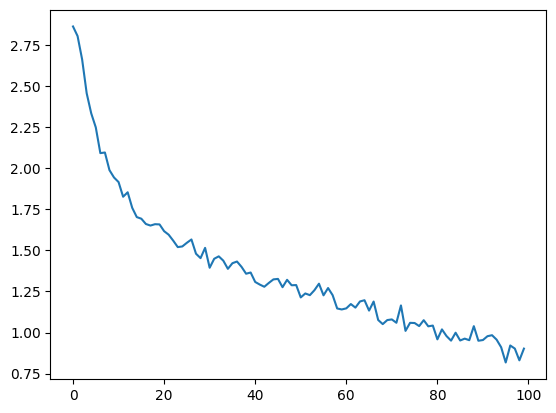

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


/tmp/ipykernel_30951/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_30951/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


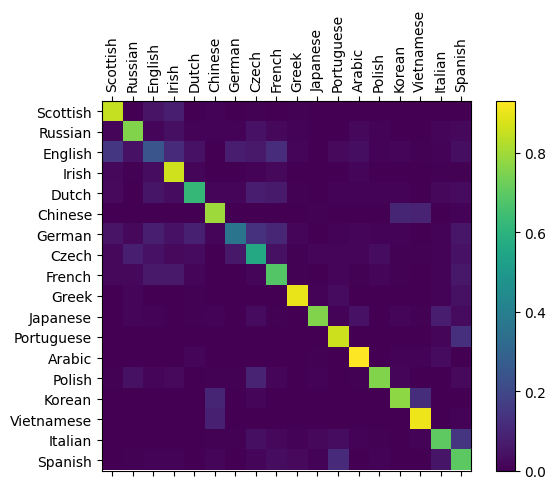

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.81) Czech
(-1.21) Russian
(-1.72) English

> Jackson
(-0.08) Scottish
(-2.97) English
(-4.62) Russian

> Satoshi
(-0.07) Japanese
(-3.25) Italian
(-4.18) Arabic


The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)
split the above code into a few files:

-   `data.py` (loads files)
-   `model.py` (defines the RNN)
-   `train.py` (runs training)
-   `predict.py` (runs `predict()` with command line arguments)
-   `server.py` (serve prediction as a JSON API with `bottle.py`)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions:

``` {.sourceCode .sh}
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit <http://localhost:5533/Yourname> to get JSON
output of predictions.


Exercises
=========

-   Try with a different dataset of line -\> category, for example:
    -   Any word -\> language
    -   First name -\> gender
    -   Character name -\> writer
    -   Page title -\> blog or subreddit
-   Get better results with a bigger and/or better shaped network
    -   Add more linear layers
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network
